# 计图 NLP 教程 - BERT分类器
本教程最后更新于 2022.4.16

#### 任务描述：
IMDb 影评分类问题。程序将根据给出的英文影评，判断其为正面评价（Positive），或是负面评价（Negative）。  
注意：正面评价将用数字 “1” 表示，负面评价将用数字 “0” 表示。

*示例：*  
> 影评内容：  
> Magnificent and unforgettable, stunningly atmospheric, and brilliantly acted by all. I really cannot understand what sort of people are panning this masterpiece and giving the preponderance of votes as 8 (and nine ones!) This, along with Grapes of Wrath, is John Ford's greatest movie. I would say that Long Voyage Home is next in line, though quite a way back. Rating: 10. It deserves a 12.   
> (该条英文评论为正面评价。)  
>  
> 正确标签：1  


#### 解决流程：
本程序将按照以下几个步骤，解决目标任务:
1. 准备工作  
2. 数据处理 
3. 加载模型及优化器  
4. 训练 
5. 测试 


## 1. 准备工作

导入计图，以及其他通用包，并开启 GPU 加速。

In [ ]:
# 加载计图，以及其他通用包
import jittor as jt
import time

# 开启 GPU 加速
jt.flags.use_cuda = 1

## 2. 数据处理

### 2.1 下载并读取数据

本项目所使用的数据集为 **IMDb 影评** 数据集。原数据集由 [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/)  网页提供。

这里，我们直接从 Jittor 服务器下载该数据集。

In [2]:
from jittor_utils.misc import download_url_to_local

download_url_to_local(
    url="https://cg.cs.tsinghua.edu.cn/jittor/assets/build/checkpoints/aclImdb_train.csv", 
    filename="aclImdb_train.csv", 
    root_folder="./", 
    md5=None)

随后，我们利用 Pandas 读取下载到本地的数据集。

In [3]:
import pandas as pd

imdb_data = pd.read_csv("aclImdb_train.csv", header=0, names=['Text', 'Label'])

现在，让我们直观的查看一下，我们所拿到的数据集。

In [4]:
# 展示文本 Text 及其标签 Label
imdb_data

,Text,Label
0,"Magnificent and unforgettable, stunningly atmo...",1
1,I got hooked on this as apparently ABC has lic...,1
2,(SPOILERS IN FIRST PARAGRAPH) This movie's ant...,1
3,"Masayuki Suo, who directed this fine film, is ...",1
4,It is a well known fact that when Gene Roddenb...,1
...,...,...
24995,"As a big fan of David Mamet's films and plays,...",0
24996,There seems to be an overwhelming response to ...,0
24997,"For the first couple of seasons, I thought The...",0
24998,WE FAW DOWN <br /><br />Aspect ratio: 1.33:1<b...,0


In [5]:
# 查看数据集上标签为 0 和 1 的数据个数
imdb_data["Label"].value_counts()

0    12500
1    12500
Name: Label, dtype: int64

In [6]:
# 浏览第一个数据文本
print(u"文本：\n%s\n" % imdb_data["Text"][0])
print(u"标签：%s" % imdb_data["Label"][0])

文本：
Magnificent and unforgettable, stunningly atmospheric, and brilliantly acted by all.<br /><br />I really cannot understand what sort of people are panning this masterpiece and giving the preponderance of votes as 8 (and nine ones!)<br /><br />This, along with Grapes of Wrath, is John Ford's greatest movie. I would say that Long Voyage Home is next in line, though quite a way back.<br /><br />Rating: 10. It deserves a 12.

标签：1


最后，我们将 **数据集** 切分成 **训练集** 和 **测试集**。

In [7]:
# 为节省时间，只抽取部分数据做演示
imdb_data = imdb_data.sample(frac=0.2) 

# 按比例切分“训练集”和“测试集”。利用 frac 设置切分的比例
train_data = imdb_data.sample(frac=0.5) 
test_data = imdb_data.drop(train_data.index)
train_data["Label"].value_counts()

1    1258
0    1242
Name: Label, dtype: int64

### 2.2 分词（Tokenization）

In [8]:
from tokenization import BertTokenizer

vocab_file = "./tokenization/vocab.txt"
tokenizer = BertTokenizer(do_lower_case=True, model_max_length=512, vocab_file=vocab_file)

# 对文本进行分词
train_encodings = tokenizer(list(train_data["Text"]), padding=True)
test_encodings = tokenizer(list(test_data["Text"]), padding=True)

### 2.3 将数据存入 Dataset 对象中
定义一个 Dataset 类，并将完成 Tokenization 后的数据文本（encodings）和数据标签（labels）封装为数据对象，以便模型使用。

In [9]:
class IMDbDataset(jt.dataset.Dataset):
    def __init__(self, encodings, labels):
        super().__init__()
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: jt.array(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = jt.array(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
train_dataset = IMDbDataset(train_encodings, list(train_data["Label"])).set_attrs(batch_size=4, shuffle=True)
test_dataset = IMDbDataset(test_encodings, list(test_data["Label"])).set_attrs(batch_size=1, shuffle=False)

## 3. 加载模型及优化器
加载 BERT 模型和 AdamW 优化器。

In [10]:
from model import BertClassification, BertConfig
from jittor.optim import AdamW

# 加载 BERT 模型
configuration = BertConfig()
model = BertClassification(configuration)
model.load_state_dict(jt.load("jittorhub://pretrained_bert.bin")) # 加载预训练的参数

# 加载 AdamW 优化器
optim = AdamW(model.parameters(), lr=1e-5)

## 4. 训练

首先，准备一个实用方法。目标是将模型的输出转化为预测值“1” 和 “0”，与原本的数据标签所对应。

In [11]:
# 预测
def predict(outputs):
    probabilities = jt.nn.softmax(outputs["logits"], dim=1)
    predictions = jt.argmax(probabilities, dim=1)[0]
    return predictions

训练模型

In [12]:
# 训练代码
from tqdm import tqdm

# 设置训练周期为 3
epoch = 3

# 开启训练模式
model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_dataset, total=len(train_dataset)//train_dataset.batch_size)
    for batch in pbar:
        
        optim.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        optim.step(loss)
        
        # 基于模型的输出进行预测
        predictions = predict(outputs)

        # 计算准确率 accuracy
        correct += predictions.equal(labels.reshape(-1)).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # 显示进度条指标
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # 记录每个批次的损失值 loss
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # 记录每个 epoch 的 loss 和 accuracy
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/3


100%|██████████| 625/625 [00:46<00:00, 13.45it/s, Loss=0.129, Accuracy=0.775]


Epoch 2/3


100%|██████████| 625/625 [00:48<00:00, 13.01it/s, Loss=0.144, Accuracy=0.905]


Epoch 3/3


100%|██████████| 625/625 [00:49<00:00, 12.55it/s, Loss=0.166, Accuracy=0.959]


可视化训练损失 loss 和 准确率 accuracy

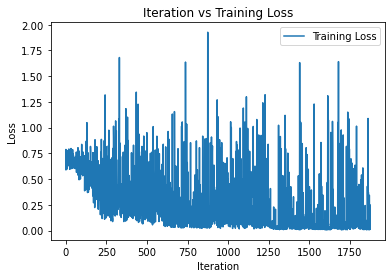

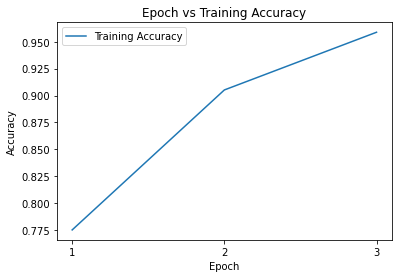

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 每个迭代 vs. 损失
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# 每个纪元 vs. 准确率
acc_X = np.arange(len(train_accuracies))+1      # 重置 X 轴坐标
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. 测试

In [14]:
# 测试代码

# 开启测试模式
model.eval()

with jt.no_grad():  # 关闭梯度
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_dataset, total=len(test_dataset)//test_dataset.batch_size)
    for batch in pbar:

        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # 基于模型的输出进行预测
        predictions = predict(outputs)

        # 计算准确率 accuracy
        correct += predictions.equal(labels.reshape(-1)).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # 显示进度条指标
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # 记录结果
        record["labels"] += list(labels.reshape(-1).numpy())
        record["predictions"] += list(predictions.numpy())
        
    pbar.close()
    
time.sleep(0.3)
print(u"测试集上准确率: %s%%" % round(accuracy*100,4))

100%|██████████| 2500/2500 [00:37<00:00, 67.22it/s, loss=0.025, accuracy=0.830]


测试集上准确率: 82.96%


查看结果

In [15]:
# 将测试结果转化为 pandas DataFrame 对象
from pandas.core.frame import DataFrame
df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# 拼接测试文本和测试结果
df = pd.concat([test_data.reset_index(), df_record["Model Prediction"]], axis=1)

# 显示测试结果
# pd.set_option('display.max_rows', None)    # 查看所有行
# df

# 只显示错误的预测 
df[df["Label"]!=df["Model Prediction"]]

,index,Text,Label,Model Prediction
10,5573,the photography was beautiful but i had diffic...,1,0
16,20449,San Francisco is a big city with great acting ...,0,1
17,20133,"Okay, I've watched this movie twice now, I hav...",0,1
19,17128,This esteemed production has it's fans. But to...,0,1
24,14961,"Now, I've seen a lot of bad movies. I like bad...",0,1
...,...,...,...,...
2468,19365,You gotta love the cheesy low budget movies. T...,0,1
2485,1038,"maybe i need to have my head examined,but i th...",1,0
2486,15821,It wasn't the most pointless animation film ex...,0,1
2487,14353,When they killed off John Amos's character the...,0,1


显示测试结果的混淆矩阵

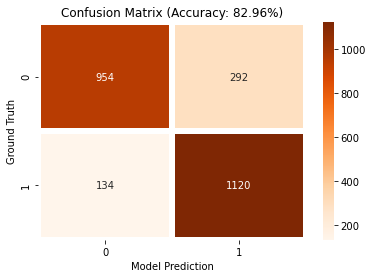

In [16]:
# 显示测试结果的混淆矩阵
import seaborn as sns
crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()

In [17]:
"""
- 手动测试 -

以下代码将用于手动测试。
可自定义输入评论，模型将判断其为正面评价还是负面评价。

如：
输入“I don't like it, beacuse it is a boring movie. It's kind of waste my time”
期待模型判断为负面评价(negative)。

注意，只能输入英文。
"""

manual_test = True
count = 1
print(u"现在开始手动测试：\n")
while(manual_test):
    
    review = input(u"请输入想要测试的影评（英文）：\n")

    # 对影评文本进行分词
    inputs = tokenizer(review, padding=True, return_tensors="jt")
    
    # 模型预测
    outputs = model(**inputs)
    prediction = predict(outputs)

    # 检查性能
    print("\n模型认为这是一条%s。\n" % (u"负面评价" if int(prediction)==0 else u"正面评价"))
    
    manual_test = input(u"再试一次？ y/n\n")=="y"
    if manual_test:
        count = count + 1
        print("--------------------------------------- %s ---------------------------------------" % count)

现在开始手动测试：

请输入想要测试的影评（英文）：
I don't like it, beacuse it is a boring movie. It's kind of waste my time

模型认为这是一条负面评价。

再试一次？ y/n
n
